# Concise representations with the deep decoder

We demonstrate the the deep decoder enables concise representations of images. Towards this goal, we represent an image with an underparametrized deep decoder with $N$ parameters, and for comparison with a wavelet respresentation that retains the $N$ largest wavelet coefficients (i.e., wavelet thresholding). 

We find that if $N$ is small relative to the number of output pixels, the deep decoder performs better (i.e., has smaller representation error).

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pyplot as plt
import numpy as np
import numbers
import pywt
import scipy
import skimage.color as color
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.measure import compare_psnr
import os
from PIL import Image
import PIL
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.optim
from torch.autograd import Variable

from include import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
print("num GPUs",torch.cuda.device_count())
#dtype = torch.FloatTensor

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)


num GPUs 1


## Functions to compute the representation error

In [2]:
def rep_error_deep_decoder(img_np,k=128,convert2ycbcr=False):
    '''
    mse obtained by representing img_np with the deep decoder
    '''
    output_depth = img_np.shape[0]
    if output_depth == 3 and convert2ycbcr:
        img = rgb2ycbcr(img_np)
    else:
        img = img_np
    img_var = np_to_var(img).type(dtype)
    
    num_channels = [k]*5
    net = decodernw(output_depth,num_channels_up=num_channels).type(dtype)
    rnd = 500
    numit = 20000
    rn = 0.01
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.005,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=True,
                               )
    out_img = net(ni.type(dtype)).data.cpu().numpy()[0]
    if output_depth == 3 and convert2ycbcr:
        out_img = ycbcr2rgb(out_img)
    return psnr(out_img,img_np), out_img, num_param(net)

def rep_error_wavelet(img_np,ncoeff=300):
    '''
    mse obtained by representing img_np with wavelet thresholding
    ncoff coefficients are retained per color channel
    '''
    if img_np.shape[0] == 1:
        img_np = img_np[0,:,:]
        out_img_np = denoise_wavelet(img_np, ncoeff=ncoeff, multichannel=False, convert2ycbcr=True, mode='hard')
    else:
        img_np = np.transpose(img_np)
        out_img_np = denoise_wavelet(img_np, ncoeff=ncoeff, multichannel=True, convert2ycbcr=True, mode='hard')
    # img_np = np.array([img_np[:,:,0],img_np[:,:,1],img_np[:,:,2]])
    return psnr(out_img_np,img_np), out_img_np

def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='Greys',interpolation='none')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')    
        
def comparison(img_np,k,convert2ycbcr=False):
    # compute representations
    psnrv, out_img_np, nparms = rep_error_deep_decoder(img_np,k=k,convert2ycbcr=convert2ycbcr)
    nchannels = img_np.shape[0]
    psnrv_wvl, out_img_np_wvl = rep_error_wavelet(img_np,ncoeff=int(nparms/nchannels))
    
    print("Compression factor: ", np.prod( img_np.shape ) / nparms )
    # plot results
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2,out_img_np)
    ax2.set_title( "Deep-Decoder representation, PSNR: %.2f" % psnrv )
    ax2.axis('off')
    #save_np_img(img_np,"exp_comp_orig.png")
    #save_np_img(out_img_np,"exp_comp_dd.png")

    ax3 = fig.add_subplot(133)
    ax3.set_title( "Wavelet representation, PSNR: %.2f" % psnrv_wvl ) 
    ax3.axis('off')
    
    if(img_np.shape[0] == 1):
        ax3.imshow(np.clip(out_img_np_wvl,0,1),cmap='Greys',interpolation='nearest')
    else:
        ax3.imshow(np.clip(out_img_np_wvl.transpose(1, 0, 2) ,0,1))
    
    plt.axis('off')
    fig.show()
    

## Representation error for a color image

The deep decoder performs similarlty well when applied to an RGB encoded color image and an YCbCr-encoded image. Wavelet compression performs better in YCbCr space, therefore we compare to wavelet thresholding a YCbCr-encoded image.

The results show that tpyically, for a large compression factor, defined as number of output pixels over the number of parameters of the representations, the deep decoder performs better in that is has a smaller representation error. For small compression factors, wavelet thresholding has a smaller error.

In [3]:
path = './test_data/'
img_name = "sf4_rgb"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

shape:  [1, 64, 16, 16]
optimize with adam 0.005
Compression factor:  30.796992481203006 Actual loss 0.004689 Actual loss orig 0.004689  Noise Energy 0.000000 


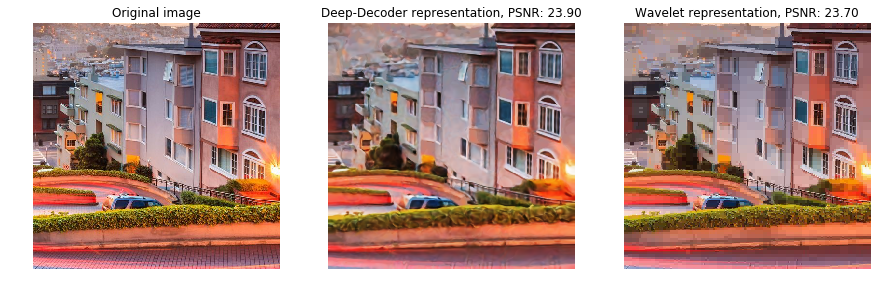

In [4]:
comparison(img_np,64,convert2ycbcr=False)

shape:  [1, 64, 16, 16]
optimize with adam 0.005
Compression factor:  30.796992481203006 Actual loss 0.015515 Actual loss orig 0.015515  Noise Energy 0.000000 


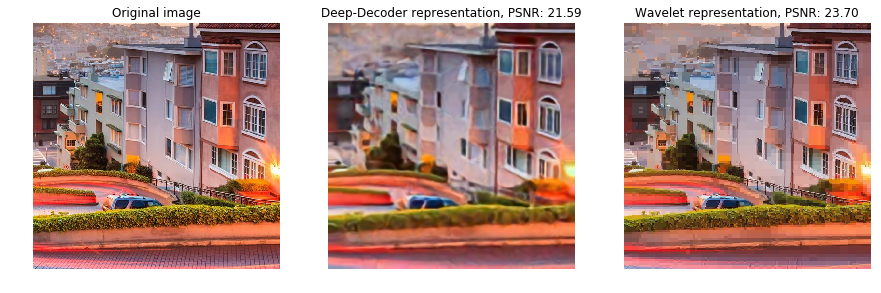

In [5]:
comparison(img_np,64,convert2ycbcr=True)

shape:  [1, 128, 16, 16]
optimize with adam 0.005
Compression factor:  7.846743295019157  Actual loss 0.004753 Actual loss orig 0.004753  Noise Energy 0.000000 


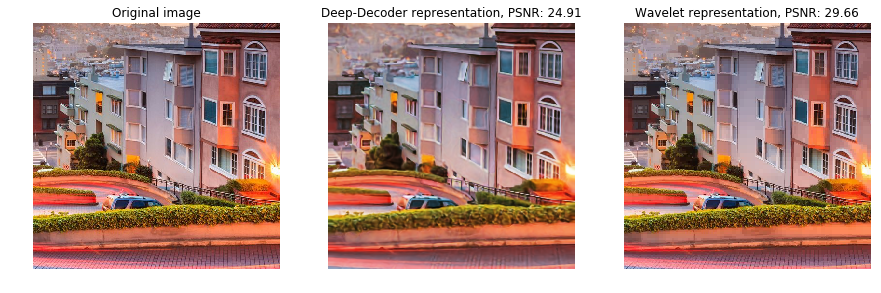

In [6]:
comparison(img_np,128,convert2ycbcr=False)

shape:  [1, 128, 16, 16]
optimize with adam 0.005
Compression factor:  7.846743295019157  Actual loss 0.015497 Actual loss orig 0.015497  Noise Energy 0.000000 


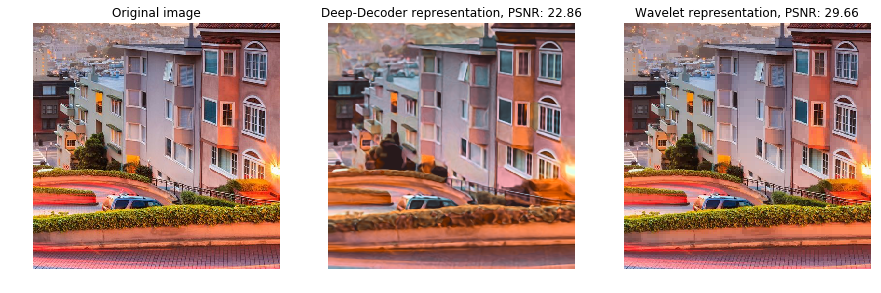

In [7]:
comparison(img_np,128,convert2ycbcr=True)

## Representation error for a greyscale image

In [8]:
path = './test_data/'
img_name = "mri"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

shape:  [1, 32, 16, 16]
optimize with adam 0.005
Compression factor:  39.96097560975614  Actual loss 0.001824 Actual loss orig 0.001824  Noise Energy 0.000000 


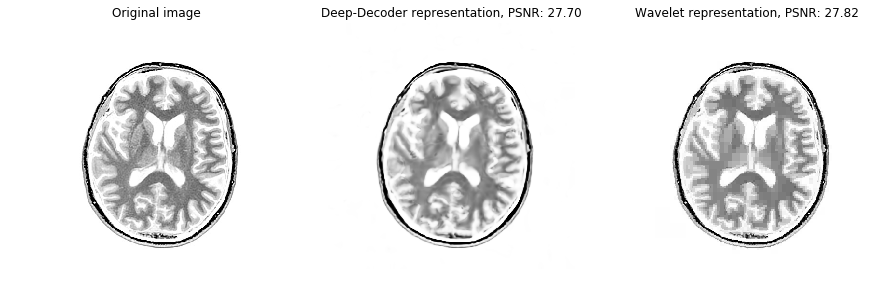

In [9]:
comparison(img_np,32)

shape:  [1, 64, 16, 16]
optimize with adam 0.005
Compression factor:  10.317380352644836 Actual loss 0.000770 Actual loss orig 0.000770  Noise Energy 0.000000 


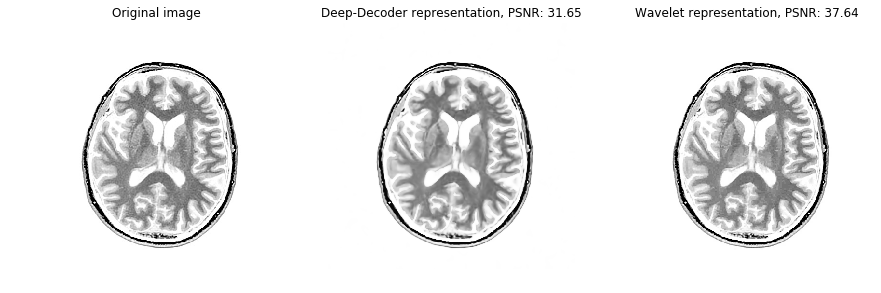

In [10]:
comparison(img_np,64)